# Example 3: An interactive plot - LHC BBQ Spectrum

Author: Michael Betz, CERN BE-BI

## Setup

In [1]:
%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import display
import numpy as np

This constant is used to normalise the frequency axis of the BBQ Spectrum, it is the revolution frequency of the LHC (in Hz).

In [2]:
F_REV = 11.245e3

For this example we will initialize PyJapc in "safe mode" so all sets are only simulated (i.e. are not written to the device).

In [3]:
import pyjapc

japc = pyjapc.PyJapc( selector="LHC.USER.ALL", incaAcceleratorName="LHC", noSet=True )

## RBAC Login

This example communicates with a device in the LHC, so an RBAC login is needed! 

On a suitably priviledged machine, you can perform a login by location (without a username or password) with:

In [4]:
japc.rbacLogin()

Otherwise you need to provide the `username=` parameter and will be prompted for a password:

    japc.rbacLogin(username="testuser")
    
Finally, a built in password prompt is provided which can be activated using:

    japc.rbacLogin(loginDialog=True)

## Create plots for four FESA parameters

This demonstrates how to use `subplots()` to create several plots in one window. Details on how to deal with the plotting are given [here](http://matplotlib.org/users/recipes.html#easily-creating-subplots).

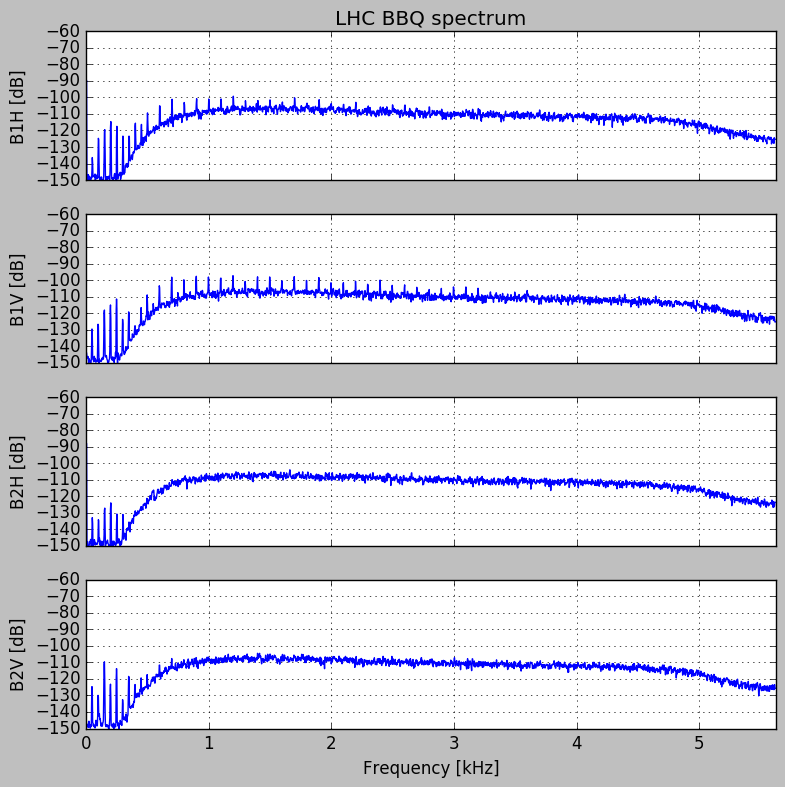

In [7]:
parSpectList = ["LHC.BQ.ONDEMAND.B1/SummaryMeasurement#averageMagnitudeH", 
                "LHC.BQ.ONDEMAND.B1/SummaryMeasurement#averageMagnitudeV",
                "LHC.BQ.ONDEMAND.B2/SummaryMeasurement#averageMagnitudeH",
                "LHC.BQ.ONDEMAND.B2/SummaryMeasurement#averageMagnitudeV"]

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=[8,8])
axs = axs.flatten()
lines = list()
for i,par in enumerate(parSpectList):
    v = japc.getParam( par )
    xVect = np.linspace( 0, F_REV/2, len(v), endpoint=False )
    ax = axs[i]
    lines.append( ax.plot( xVect/1e3, v, label=par )[0] )
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_ylabel( "{0} [dB]".format(par[16:18] + par[-1]) )
ax.axis((0, F_REV/2000, -150, -60))
ax.set_xlabel( "Frequency [kHz]" )
axs[0].set_title("LHC BBQ spectrum")
plt.tight_layout()
    
display( plt.gcf() )

## Animate the plot by doing a GET periodically (polling)

**Note:** With the Qt backend, the plot only starts updating after moving the curves or zooming a little.

In [6]:
def updatePlot( n ):
    for i,par in enumerate(parSpectList):
        v = japc.getParam( par )
        xVect = np.linspace( 0, F_REV/2, len(v), endpoint=False )
        lines[i].set_data( xVect/1e3, v )

plotAni = ani.FuncAnimation( fig, updatePlot, interval=1000 )
plt.show()

You will need to close the figure to stop the animation.

## Alternatively: Animate the plot by subscribing

Instead of polling, we can subscribe to the parameters. This is better, as a GET is only done when there is actually new data available.

Plan of attack... create a callback function, which is called by JAPC when new data is received. It will update the plot with the new data and then redraw it.

**NOTE:** You will need to re-create the figure if you closed it!

In [8]:
def onValueReceived( parameterName, pVal ):
    i = parSpectList.index( parameterName )     # Get index number of plot to update
    l = lines[i]                                # Get line object of plot to update
    if len( pVal ) != len( l.get_xdata() ):     # No. of points changed, put a new X-Vector
        xVect = linspace( 0, F_REV/2, len(pVal), endpoint=False )
        l.set_data( xVect/1e3, pVal )
    else:
        l.set_ydata( pVal )
    if i == 0:                                  # Only redraw plot when first Param. changes
        l.figure.canvas.draw()

Now register the callback function for all four parameters and start monitoring...

In [9]:
for par in parSpectList:
    japc.subscribeParam( par, onValueReceived )

japc.startSubscriptions()

When finished, stop the monitoring...

In [10]:
japc.stopSubscriptions()

Don't forget to logout of RBAC...

In [11]:
japc.rbacLogout()